In [1]:
# python
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("ATLAS")
import sys
sys.path.append("../")

# custom
import Utils as ut
from Utils import loadALEPH2004Result, loadWeights, ensembleWeights, calc_hist, plotThrust
import dataloader

aleph = ut.loadALEPH2004Result()

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


/global/u1/b/badea/aleph/unfold-ee-logtau/temp/Utils.py:86: RuntimeWarning: divide by zero encountered in log
  aleph_log_bins = np.log(aleph_bins)


In [2]:
# Load the data
data_conf = {
    'f_data':'/global/homes/b/badea/aleph/data/ThrustDerivation/030725/LEP1Data1994_recons_aftercut-MERGED_thrust.root',
    'f_mc':'/global/homes/b/badea/aleph/data/ThrustDerivation/030725/alephMCRecoAfterCutPaths_1994_thrust.root',
    'SystematicVariation': 1, # chosen selection
  }
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader(data_conf)
# flatten
reco_data = reco_data.flatten()
reco_mc = reco_mc.flatten()
gen_mc = gen_mc.flatten()
print(reco_data.shape, reco_mc.shape, gen_mc.shape, pass_reco.shape, pass_gen.shape)
# apply selection
reco_mc = reco_mc[pass_reco]
gen_mc = gen_mc[pass_gen] # fully efficient
print(reco_mc.shape, gen_mc.shape)

(1326338,) (973769,) (973769,) (973769,) (973769,)
(751854,) (973769,)


In [3]:
# Load the weights
N = 10
ensemble = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-745de56e/*/model_weights*"
ensemble_weights = ensembleWeights(loadWeights(ensemble), N=N)
print(ensemble_weights.shape)

systematic = "/global/homes/b/badea/aleph/unfold-ee-logtau/results/training-439c81ff/*/model_weights*"
systematic_weights = ensembleWeights(loadWeights(systematic), N=N)
print(systematic_weights.shape)

(1, 20, 973769)
(5, 1, 973769)


In [4]:
# plotting configuration
conf = {
    "logtau" : {
        "aleph" : {
            "x" : aleph["aleph_log_midbins"], 
            "y": aleph["aleph_log_thrust"], 
            "xerr": aleph["aleph_log_binwidths"]/2, 
            "yerr": aleph["aleph_log_thrust_errs"], 
            "bins" : aleph["aleph_log_bins"]
        },
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax2_xscale" : "linear",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_xlabel" : "log(1-T)",
        "ax2_ylim" : [0.01, 1.99],
        "bins" : np.linspace(aleph["log_bins_min"], np.log(0.5), 51),
        "legend" : "lower right",
        "legend_bbox" : (0.98, 0.0)
    },
    # "thrust" : {
    #     "aleph" : {
    #         "x" : aleph["aleph_midbins"], 
    #         "y": aleph["aleph_thrust"], 
    #         "xerr": aleph["aleph_binwidths"]/2, 
    #         "yerr": aleph["aleph_thrust_errs"], 
    #         "bins" : aleph["aleph_bins"]
    #     },
    #     "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/d(1-T)",
    #     "ax1_yscale" : "log",
    #     "ax2_xscale" : "linear",
    #     "ax1_ylim" : [0.3*10**-3, 4*10**1],
    #     "ax2_xlabel" : "1-T",
    #     "ax2_ylim" : [0.68, 1.32],
    #     "bins" : np.linspace(0, 0.45, 51),
    #     "legend" : "lower left",
    #     "legend_bbox" : (0.05, 0.0)
    # }
}    

In [5]:
# make histograms
plots = {}
for key, val in conf.items():
    plots[key] = {}
    for binType in ["nominal", "aleph"]:
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        # data histograms
        plots[key][f"data_{binType}"] = calc_hist(reco_data, bins=bins, density=True) # = counts_data, errors_data, bin_edges
        # mc reco histograms
        plots[key][f"mc_reco_{binType}"] = calc_hist(reco_mc, bins=bins, density=True)
        # gen before histograms
        plots[key][f"mc_genBefore_{binType}"] = calc_hist(gen_mc, bins=bins, density=True)
        # unifold histograms
        for iW, weights in enumerate(np.squeeze(ensemble_weights, axis=0)):
            plots[key][f"unifold_{binType}_ensemble{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())
        for iW, weights in enumerate(systematic_weights):
            plots[key][f"unifold_{binType}_systematic{iW}"] = calc_hist(gen_mc, bins=bins, density=True, weights=weights.flatten())

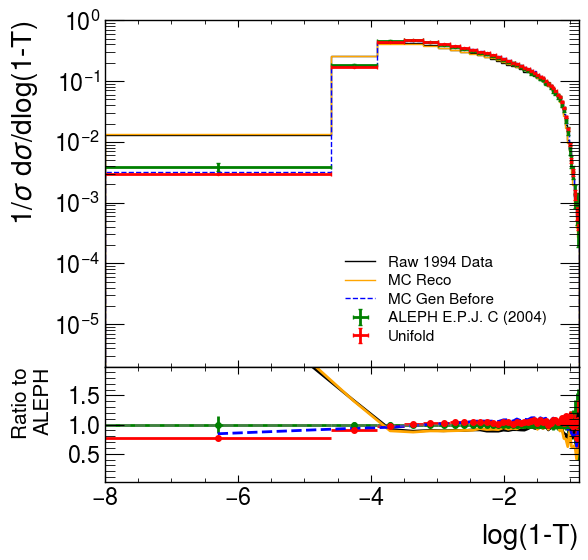

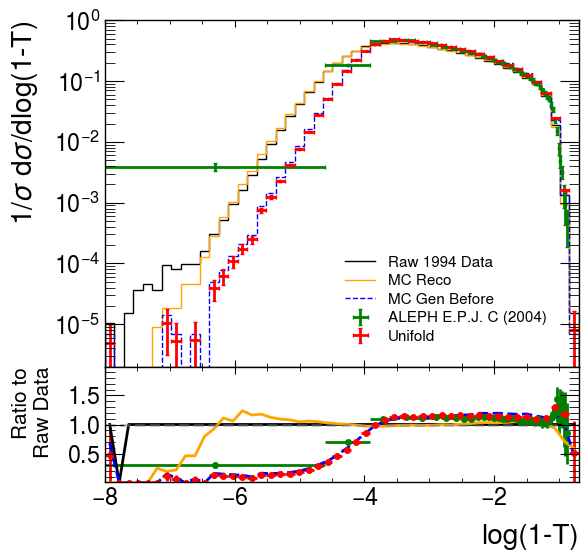

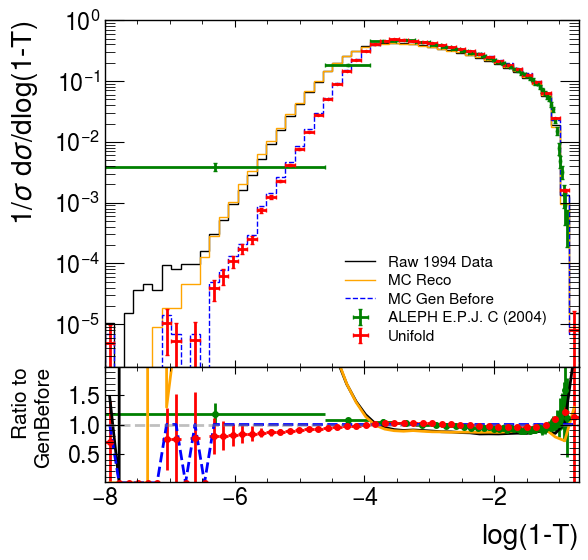

In [8]:
for key, val in conf.items():
    for ratioTo in ["aleph", "data", "genBefore"]:

        # bins
        binType = "aleph" if ratioTo == "aleph" else "nominal"
        bins = val["aleph"]["bins"] if ratioTo == "aleph" else val["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # define denominator for ratio
        if ratioTo == "aleph":
            ratio_denom = [val["aleph"]["y"]]
            ax2_ylabel = f'Ratio to\nALEPH'
        elif ratioTo == "data":
            ratio_denom = [plots[key][f"data_{binType}"][0], plots[key][f"data_aleph"][0]]
            ax2_ylabel = f'Ratio to\nRaw Data'
        elif ratioTo == "genBefore":
            ratio_denom = [plots[key][f"mc_genBefore_{binType}"][0], plots[key][f"mc_genBefore_aleph"][0]]
            ax2_ylabel = f'Ratio to\nGenBefore'
        else:
            print("nothing")
        
        # style
        style = {
            "legend_loc" : val["legend"],
            "legend_bbox" : val["legend_bbox"],
            "legend_ncol" : 1,
            "ax1_ylabel" : val["ax1_ylabel"],
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : ax2_ylabel,
            "ax1_ylim" : val["ax1_ylim"],
            "bins" : bins,
            "ax2_ylim" : val["ax2_ylim"],
        }

        # inPlots
        inPlots = {}
        inPlots["aleph"] = {"plotType": "errorbar", "x": val["aleph"]["x"], "y": val["aleph"]["y"], "color": "green", "label": 'ALEPH E.P.J. C (2004)', "xerr":val["aleph"]["xerr"], "yerr":val["aleph"]["yerr"]}
        inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": plots[key][f"unifold_{binType}_ensemble0"][0], "color": "red", "label": "Unifold", "xerr":binwidths/2, "yerr":plots[key][f"unifold_{binType}_ensemble0"][1]}
        inPlots["data"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"data_{binType}"][0], "color": "black", "label": "Raw 1994 Data", "ls":"-"}
        inPlots["mc_reco"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"mc_reco_{binType}"][0], "color": "orange", "label": "MC Reco", "ls":"-"}
        inPlots["mc_genBefore"] = {"plotType": "stairs", "x": bins, "y": plots[key][f"mc_genBefore_{binType}"][0], "color": "blue", "label": "MC Gen Before", "ls":"--"}

        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        plt.show()
        plt.close()
        



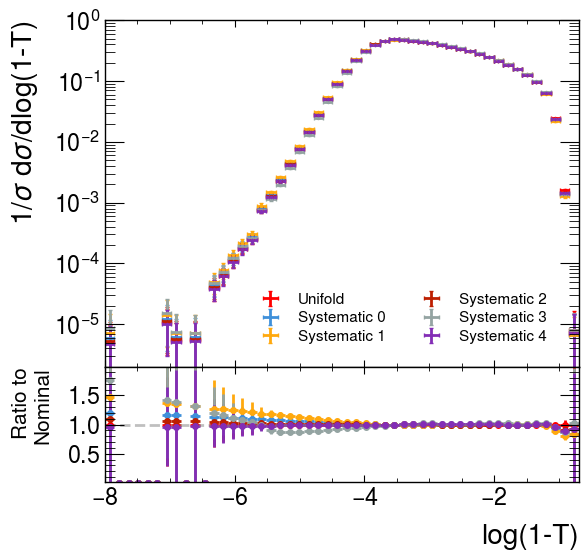

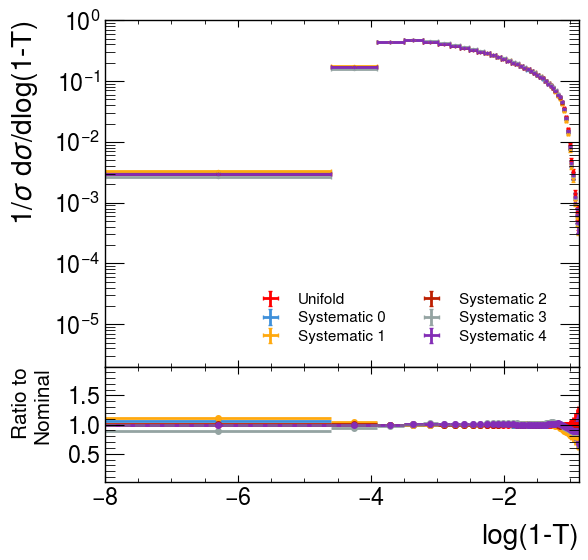

In [13]:
for key, val in conf.items():
    for binType in ["nominal", "aleph"]:
        
        # bins
        bins = val["bins"] if binType == "nominal" else val["aleph"]["bins"]
        binwidths = bins[1:] - bins[:-1]
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # style
        style = {
            "legend_loc" : val["legend"],
            "legend_bbox" : val["legend_bbox"],
            "legend_ncol" : 2,
            "ax1_ylabel" : val["ax1_ylabel"],
            "ax1_yscale" : val["ax1_yscale"],
            "ax2_xlabel" : val["ax2_xlabel"],
            "ax2_xscale" : val["ax2_xscale"],
            "ax2_ylabel" : f'Ratio to\nNominal',
            "ax1_ylim" : val["ax1_ylim"],
            "bins" : bins,
            "ax2_ylim" : val["ax2_ylim"],
        }

        # pick up nominal
        nominal = plots[key][f"unifold_{binType}_ensemble0"]
        ratio_denom = [nominal[0]]

        # inPlots
        inPlots = {}
        inPlots["unifold"] = {"plotType": "errorbar", "x": bin_centers, "y": nominal[0], "color": "red", "label": "Unifold", "xerr":binwidths/2, "yerr":nominal[1]}
        systList = [
            ["ensemble", 0], #ensemble_weights.shape[1]],
            ["systematic", systematic_weights.shape[0]]
        ]
        for systType, iWRange in systList:
            for iW in range(iWRange):
                inPlots[f"unifold_{binType}_{systType}{iW}"] = {
                    "plotType": "errorbar", 
                    "x": bin_centers, 
                    "y": plots[key][f"unifold_{binType}_{systType}{iW}"][0], 
                    "color": None, 
                    "label": f"{systType.title()} {iW}", 
                    "xerr": binwidths/2, 
                    "yerr": plots[key][f"unifold_{binType}_{systType}{iW}"][1]
                }

        fig, (ax1, ax2) = plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
        plt.show()
        plt.close()